## Climate data - GSWP3 and COSMO-REA6 vs. VCG precipitation observations

started 2023-04-21 from [LSP paper notebook](https://zenodo.org/record/7310652).

This notebook compares precipitation forcing from GSWP3 and COSMO-REA6 to observations from the Vestland Climate Grid.

In [47]:
import xarray as xr  # NetCDF data handling
import matplotlib.pyplot as plt  # Plotting
import pandas as pd  # Tabular data handling
import time  # Keeping track of runtime
import json  # For reading data dictionaries stored in json format
import datetime as dt  # for workaround with long simulations (beyond year 2262)
from pathlib import Path
import urllib.request  
import shutil
import zipfile

#### Load model forcing data

In [48]:
%%bash
pwd

/mnt/c/Users/evaler/OneDrive - Universitetet i Oslo/Eva/PHD/FATES_INCLINE/src/analysis_and_plotting


In [49]:
# Define site code and path to climate forcing
site_code = "ALP4"
gswp3_path = Path("../../data/ALP4/datmdata/")
cosmorea6_path = Path("../../data/ALP4_cosmorea_noleap/datmdata/")

In [50]:
# Load netcdf data
start_time = time.time()

gswp3_precipitation = xr.open_mfdataset(
    f'{gswp3_path}/clmforc*Prec.{site_code}*.nc',
    concat_dim='time',
    combine='nested',
    decode_times=True
)

cosmo_climate_data = xr.open_mfdataset(
    f'{cosmorea6_path}/*.nc',
    concat_dim='time',
    combine='nested',
    decode_times=True
)

print(f"--- Time it took to read the data: {round(float(time.time() - start_time), 3)} seconds ---")

--- Time it took to read the data: 150.615 seconds ---


## Observation data

#### Read observation data

Temperature data downloaded and subset from https://osf.io/s9k7c (accessed 2025-05-07). Daily values.

In [51]:
obs_precipitation_df = pd.read_csv(Path(f"../../data/VCG/climate/VCG_clean_gridded_daily_precipitation_SKJ_2008-2022.csv"), low_memory=False)

#### Plot layout and save path settings

In [52]:
# Define folder for saving plots
plot_save_path = Path("../../results/figures/")

if not plot_save_path.is_dir():
    plot_save_path.mkdir(parents=True, exist_ok=True)

In [53]:
# Set general plotting optionscm = 1/2.54  # centimeters in inches
cm = 1/2.54  # centimeters in inches
DPI = 200
FIG_SIZE_CM = (9.5*cm, 7*cm)
TICK_LABEL_FONT_SIZE = 9
AX_LABEL_FONT_SIZE = 11

In [54]:
obs_precipitation_df.head()

,Unnamed: 0,date,siteID,variable,value
0,203680,2008-01-02,Skjelingahaugen,precipitation,0.0
1,203685,2008-01-03,Skjelingahaugen,precipitation,0.0
2,203690,2008-01-04,Skjelingahaugen,precipitation,0.0
3,203695,2008-01-05,Skjelingahaugen,precipitation,0.0
4,203700,2008-01-06,Skjelingahaugen,precipitation,0.2


In [55]:
print(f"Shape: {obs_precipitation_df.shape}")
print(f"Data types:\n{obs_precipitation_df.dtypes}")

Shape: (5092, 5)
Data types:
Unnamed: 0      int64
date           object
siteID         object
variable       object
value         float64
dtype: object


In [56]:
# Convert date column to datetime, only keep date and value columns
obs_prec_df = obs_precipitation_df
obs_prec_df['date'] = pd.to_datetime(obs_prec_df['date']).dt.tz_localize('UTC')

obs_prec_df.drop(labels=['Unnamed: 0','siteID'], axis=1, inplace=True)

print(f"Data types:\n{obs_prec_df.dtypes}")
obs_prec_df.head()

Data types:
date        datetime64[ns, UTC]
variable                 object
value                   float64
dtype: object


,date,variable,value
0,2008-01-02 00:00:00+00:00,precipitation,0.0
1,2008-01-03 00:00:00+00:00,precipitation,0.0
2,2008-01-04 00:00:00+00:00,precipitation,0.0
3,2008-01-05 00:00:00+00:00,precipitation,0.0
4,2008-01-06 00:00:00+00:00,precipitation,0.2


In [57]:
obs_prec_df.index

RangeIndex(start=0, stop=5092, step=1)

In [58]:
# Set date as index
obs_prec_df.set_index('date', inplace=True)

KeyError: 'date'

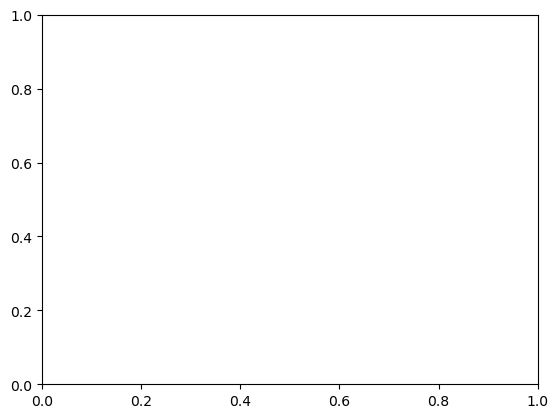

In [59]:
# Quick visualization
fig, ax = plt.subplots()
ax.plot(obs_precipitation_df['date'], 
        obs_precipitation_df['value']
       )
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")
plt.title("Observed daily precipitation")

## GSWP3
Load data from xarray Dataset into a pandas DataFrame.

In [ ]:
gswp3_df = pd.DataFrame(columns=['date', 'precipitation'])

# Subset date, convert to datetime format. Expect a warning due to GSWP3 special NOLEAP calendar format.
gswp3_df['date'] = gswp3_precipitation.indexes['time'].to_datetimeindex()

# Subset precipitation, convert from [mm H2O / sec] to total (3h=10800s model time step)
gswp3_df['precipitation'] = gswp3_precipitation["PRECTmms"].values.flatten() * 10800

In [ ]:
gswp3_df.head()

In [ ]:
# Quick visualization
fig, ax = plt.subplots()
ax.plot(gswp3_df['date'], 
        gswp3_df['precipitation']
       )
ax.set_title("GSWP3 precipitation")
ax.set_xlabel("Date")
ax.set_ylabel("precipitation")

In [ ]:
# Calculate daily means
gswp3_daily_prec_df = gswp3_df.groupby(pd.Grouper(key='date', freq='D'))['precipitation'].mean()

In [ ]:
gswp3_daily_prec_df.head()

In [ ]:
# Quick visualization 
fig, ax = plt.subplots()
ax.plot(gswp3_daily_prec_df.index, 
        gswp3_daily_prec_df.values
       )
ax.set_title("GSWP3 - daily means")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")
ax.set_xlim(pd.Timestamp(2008, 1, 1), pd.Timestamp(2015, 1, 1))

## COSMO-REA6

Format and get daily means of COSMO-REA6 forcing in the same way as GSWP3

In [ ]:
cosmo_df = pd.DataFrame(columns=['date', 'precipitation'])

# Subset date, convert to datetime format. Expect a warning due to GSWP3 special NOLEAP calendar format.
cosmo_df['date'] = cosmo_climate_data.indexes['time'].to_datetimeindex()

# Subset precipitation, convert from [mm H2O / sec] to total (3h=10800s model time step)
cosmo_df['precipitation'] = cosmo_climate_data["PRECTmms"].values.flatten() * 10800

In [ ]:
cosmo_df.head()

In [ ]:
# Quick visualization
fig, ax = plt.subplots()
ax.plot(cosmo_df['date'], 
        cosmo_df['precipitation']
       )
ax.set_title("COSMO-REA6 precipitation")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")

In [ ]:
# Calculate daily means
cosmo_daily_prec_df = cosmo_df.groupby(pd.Grouper(key='date', freq='D'))['precipitation'].mean()
cosmo_daily_prec_df.head()

In [ ]:
# Quick visualization 
fig, ax = plt.subplots()
ax.plot(cosmo_daily_prec_df.index, 
        cosmo_daily_prec_df.values
       )
ax.set_title("COSMO-REA6 - daily means")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")
ax.set_xlim(pd.Timestamp(2008, 1, 1), pd.Timestamp(2015, 1, 1))

## Plot data sets together

In [ ]:
print(type(obs_prec_df['value'].iloc[0]))

In [ ]:
fig, ax = plt.subplots(dpi=DPI, figsize=FIG_SIZE_CM)

# GSWP3
ax.plot(gswp3_daily_prec_df.index, 
        gswp3_daily_prec_df.values,
        linewidth=1.2,
        color="navy",
        label="GSWP3 forcing"
       )

# COSMO-REA6
ax.plot(cosmo_daily_prec_df.index,
        cosmo_daily_prec_df.values,
        linewidth=1.2,
        color="cornflowerblue",
        label="COSMO-REA6 forcing")

# VCG
ax.plot(obs_prec_df.index,
        obs_prec_df.values,
        linewidth=1.2,
        linestyle="dotted",
        alpha=0.8,
        color="red",
        label="Local observations"
       )


ax.set_ylabel("Precipitation", fontsize=AX_LABEL_FONT_SIZE)
ax.set_xlabel("Year", fontsize=AX_LABEL_FONT_SIZE)
ax.set_title("Precipitation comparison of forcing data and observations")

#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_xlim(pd.Timestamp(2006, 1, 1), pd.Timestamp(2021, 1, 1))
ax.set_xticks(
    [pd.Timestamp(2006, 1, 1),
     pd.Timestamp(2015, 1, 1),
     pd.Timestamp(2021, 1, 1)]
)

ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE)

import matplotlib.dates as mdates
my_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(my_format)

ax.grid()
ax.legend(fontsize=TICK_LABEL_FONT_SIZE)

# Number of y-ticks
ax.set_yticks([-40, -20, 0, 20])

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{plot_save_path}/gswp3_vcg_precipitation.png", format='png')

#### Directly compare corresponding values

In [ ]:
temp_bias_df = pd.DataFrame(columns=['date', 'vcg_obs'])

# Add values, merge on dates (reset timezone in obs to prevent error)
temp_bias_df['date'] = pd.to_datetime(obs_temp_daily_mean.index).tz_localize(None)
temp_bias_df['vcg_obs'] = obs_temp_daily_mean.values
temp_bias_df = temp_bias_df.join(other=gswp3_daily_temp_df, how='left', on='date')
temp_bias_df = temp_bias_df.join(other=cosmo_daily_temp_df, how='left', on='date', rsuffix='_cosmo')

# Drop rows with missing entries
temp_bias_df = temp_bias_df.dropna(axis=0)
temp_bias_df

Linear regression comparison

In [ ]:
# GSWP3 versus observations
fig, ax = plt.subplots(dpi=DPI, figsize=FIG_SIZE_CM)

ax.scatter(temp_bias_df['vcg_obs'],
           temp_bias_df['2m_temperature'],
           s=12,
           edgecolors='white',
           color="#035e7b",
           linewidth=0.3,
           alpha=0.4
          )

# 1 to 1 line
ax.plot([x+1 for x in range(-40, 40)], 
        [x+1 for x in range(-40, 40)],
        color="red",
        linestyle="--",
        label="1:1 line"
       )

# Linear regression and statistics
import numpy as np
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(temp_bias_df['vcg_obs'],
                                                                     temp_bias_df['2m_temperature']
                                                                    )
plt.axline(xy1=(0, intercept),
           slope=slope, 
           label='Linear regression',
           color='black'
          )

# Calculate root mean square error
rmse = np.sqrt(np.mean(np.square(temp_bias_df['vcg_obs'] - temp_bias_df['2m_temperature'])))

# Add lin. reg. formula and metrics as text to figure
from matplotlib.offsetbox import AnchoredText

text_box = AnchoredText(f'$y = {slope:.2f}x {intercept:+.2f}$\n$RMSE = {rmse:.2f}$ [°C]\n$r^2 = {r_value**2:.2f}$',
                        frameon=False, 
                        loc=4, 
                        pad=0,
                        prop=dict(fontsize=TICK_LABEL_FONT_SIZE)
                       )
# Text box layout
plt.setp(text_box.patch, 
         facecolor='none', 
         alpha=0.5
        )
ax.add_artist(text_box)

# General plot layout
ax.set_xlabel("VCG\nAir temperature (°C)", fontsize=AX_LABEL_FONT_SIZE)
ax.set_ylabel("GSWP3\nAir temperature (°C)", fontsize=AX_LABEL_FONT_SIZE)
offset = 5 
ax.set_xlim([min([min(temp_bias_df['vcg_obs']), min(temp_bias_df['2m_temperature'])]) - offset, 
             max([max(temp_bias_df['vcg_obs']), max(temp_bias_df['2m_temperature'])]) + offset]
           )
ax.set_ylim([min([min(temp_bias_df['vcg_obs']), min(temp_bias_df['2m_temperature'])]) - offset, 
             max([max(temp_bias_df['vcg_obs']), max(temp_bias_df['2m_temperature'])]) + offset]
           )
ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE)
ax.legend(fontsize=TICK_LABEL_FONT_SIZE)

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{plot_save_path}/gswp3_vcg_temperature_bias.png", format='png')

In [ ]:
# COSMO-REA6 versus observations
fig, ax = plt.subplots(dpi=DPI, figsize=FIG_SIZE_CM)

ax.scatter(temp_bias_df['vcg_obs'],
           temp_bias_df['2m_temperature_cosmo'],
           s=12,
           edgecolors='white',
           color="#035e7b",
           linewidth=0.3,
           alpha=0.4
          )

# 1 to 1 line
ax.plot([x+1 for x in range(-40, 40)], 
        [x+1 for x in range(-40, 40)],
        color="red",
        linestyle="--",
        label="1:1 line"
       )

# Linear regression and statistics
import numpy as np
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(temp_bias_df['vcg_obs'],
                                                                     temp_bias_df['2m_temperature_cosmo']
                                                                    )
plt.axline(xy1=(0, intercept),
           slope=slope, 
           label='Linear regression',
           color='black'
          )

# Calculate root mean square error
rmse = np.sqrt(np.mean(np.square(temp_bias_df['vcg_obs'] - temp_bias_df['2m_temperature_cosmo'])))

# Add lin. reg. formula and metrics as text to figure
from matplotlib.offsetbox import AnchoredText

text_box = AnchoredText(f'$y = {slope:.2f}x {intercept:+.2f}$\n$RMSE = {rmse:.2f}$ [°C]\n$r^2 = {r_value**2:.2f}$',
                        frameon=False, 
                        loc=4, 
                        pad=0,
                        prop=dict(fontsize=TICK_LABEL_FONT_SIZE)
                       )
# Text box layout
plt.setp(text_box.patch, 
         facecolor='none', 
         alpha=0.5
        )
ax.add_artist(text_box)

# General plot layout
ax.set_xlabel("VCG\nAir temperature (°C)", fontsize=AX_LABEL_FONT_SIZE)
ax.set_ylabel("COSMO-REA6\nAir temperature (°C)", fontsize=AX_LABEL_FONT_SIZE)
offset = 5 
ax.set_xlim([min([min(temp_bias_df['vcg_obs']), min(temp_bias_df['2m_temperature_cosmo'])]) - offset, 
             max([max(temp_bias_df['vcg_obs']), max(temp_bias_df['2m_temperature_cosmo'])]) + offset]
           )
ax.set_ylim([min([min(temp_bias_df['vcg_obs']), min(temp_bias_df['2m_temperature_cosmo'])]) - offset, 
             max([max(temp_bias_df['vcg_obs']), max(temp_bias_df['2m_temperature_cosmo'])]) + offset]
           )
ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE)
ax.legend(fontsize=TICK_LABEL_FONT_SIZE)

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{plot_save_path}/cosmorea6_vcg_temperature_bias.png", format='png')